In [77]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy

In [78]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

In [97]:
sun_data, sun_times = np.load('data/1hr_Sun_data.npy')
sun_data = sun_data[50:]
sun_times = sun_times[50:]

In [54]:
crab_data, times = np.load('data/final_data.npy')

In [55]:
crab_data.shape

(63361,)

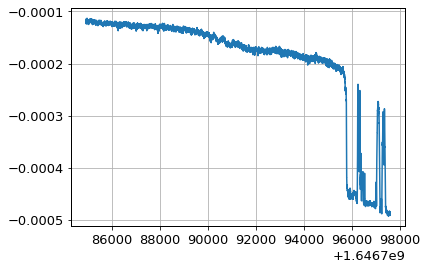

In [56]:
plt.plot(times, crab_data)

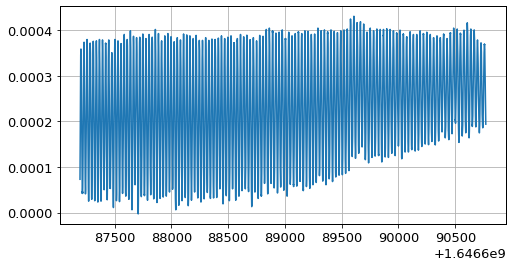

In [98]:
plt.figure(figsize=(8,4))
plt.plot(sun_times, sun_data)

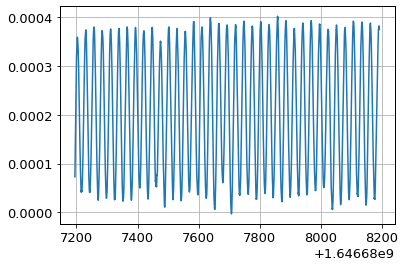

In [151]:
plt.plot(sun_times[:5000], sun_data[:5000])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


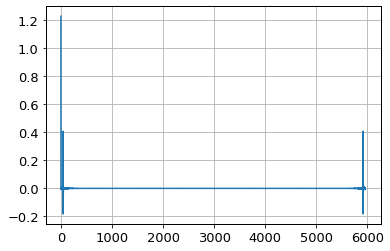

In [58]:
n = len(sun_data)
beginning, beginning_time = sun_data[:n//3], sun_times[:n//3]
middle, middle_time = sun_data[n//3:2*n//3], sun_times[n//3:2*n//3]
end, end_time = sun_data[2*n//3:], sun_times[2*n//3:]
beginning_fft = np.fft.fft(beginning)
plt.plot(beginning_fft)

In [131]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))

In [132]:
def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

Text(0.5, 1.0, 'Sun 3 Split Power Spectra')

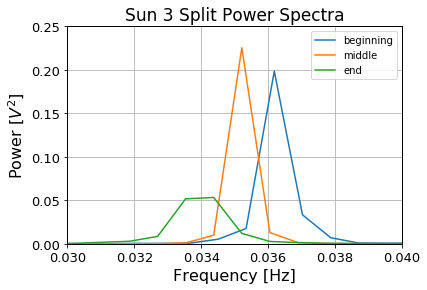

In [177]:
# dt = np.mean(np.diff(sun_times))
# beginning_freq = freq(beginning_time, dt)
# middle_freq = freq(middle_time, dt)
# end_freq = freq(end_time, dt)

# pow_beginning = pow_fft(beginning)
# pow_middle = pow_fft(middle) 
# pow_end = pow_fft(end) 
sun_data_split, sun_time_split = split_data(sun_data, sun_times, 3)
pow_beginning, pow_middle, pow_end = sun_data_split
beginning_freq, middle_freq, end_freq = sun_time_split

plt.plot(beginning_freq, pow_beginning, label="beginning")
plt.plot(middle_freq, pow_middle, label='middle')
plt.plot(end_freq, pow_end, label='end')
plt.legend()
plt.xlim(0.03,0.04)
# plt.xlim(0.0,0.1)
# plt.yscale('log')
plt.ylim(0,0.25)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$V^2$]')
plt.title('Sun 3 Split Power Spectra')

# should be power squared arbitrary units

In [65]:
sun_times[1] - sun_times[0]

0.20022296905517578

In [79]:
crab_12_data, crab_12_time = np.load('data/final_data.npy')

Text(0, 0.5, 'Power [Arbitrary]')

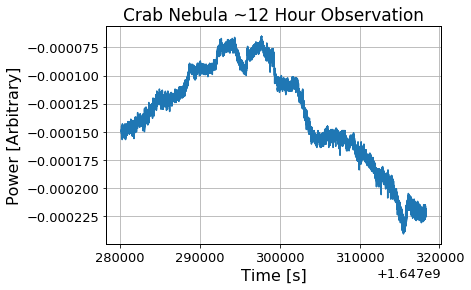

In [189]:
plt.plot(crab_12_time, crab_12_data)
plt.title('Crab Nebula ~12 Hour Observation')
plt.xlabel('Time [s]')
plt.ylabel('Power [Arbitrary]')

Text(0.5, 1.0, 'Crab Nebula 5 Split Power Spectra')

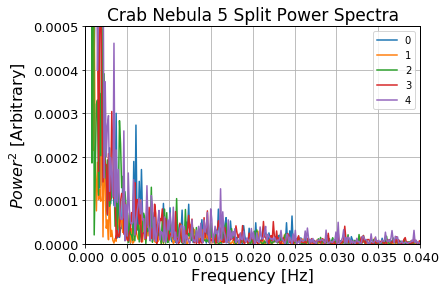

In [190]:
crab_splits, crab_freqs = split_data(crab_12_data, crab_12_time, 5)
for i in range(len(crab_splits)):
#     crab_splits[i][len(crab_splits[i])//2-1000:len(crab_splits[i])//2+1000] = 0
    plt.plot(crab_freqs[i], crab_splits[i], label=str(i))
plt.legend()
plt.xlim(0,0.04)
plt.ylim(0,.0005)
# plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$Power^2$ [Arbitrary]')
plt.title('Crab Nebula 5 Split Power Spectra')

In [ ]:
# should set dt = 1s instead of 0.1s